<a href="https://colab.research.google.com/github/allen44/endo-us-econ-analysis/blob/main/nlp_for_gdp_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective
US GDP data is released every three months. Is it possible to forecast the next GDP data release by using the data available from any source before then?

Many types of economic data are released monthly, and weekly. These data consist of numeric and non-numeric components. Using these publically available sources, this notebook will forecast the upcoming GDP release up to one quarter in the future.

# Background


## Research Review
The objective and the input data are similar to a [research paper published by the St Louis Fed in 2016.](https://research.stlouisfed.org/publications/review/2016/12/05/a-macroeconomic-news-index-for-constructing-nowcasts-of-u-s-real-gross-domestic-product-growth/) 

In this paper, the authors evaluate the usefulness of a three-way linear regression model in predicting GDP. 

>Analyzing the performance of the economy in real time is a challenge for those who must forecast macroeconomic variables such as inflation or employment. A key aspect of this challenge is evaluating the incoming flow of information contained in economic announcements. In this article, the authors develop a simple-to-read index of these announcements that they then use to construct nowcasts. The index tracks whether key economic data have come in stronger, weaker, or as expected during the current quarter relative to a baseline consensus forecast. Specifically, the data releases are weighted relative to their importance in updating forecasts of real gross domestic product growth during the current quarter.

The input data that I will use differs in that I will use NLP to process the non-numeric data in the economic data releases to create new features to use as input to a model.

## Data Selection Criteria

There are over 700 thousand economic data series that a readily accessible from the St. Louis Fed's API, and ten's of thousands more from other government and private sources. 

For this notebook, I selected a handful of 'classically important' economic measures that economist's have used for decades in predicting business cycles and guiding national economic policy. This selection process has two primary benefits:
1. These data series have been vetted by practictioner's with domain expertise and the literature shows them to be useful in a variety of contexts.
2. These data series have histories that span to multiple decades before the rise of Big Data; some series start in the 1940s and earlier.


#### Numerical Data
Most of the numerical data are aggregated from direct measures of economic activity (such as dollar of goods sold, or number of building permits issued). Other numerical data are aggregations of surveys completed by participents in the economy (such as the PMI index, or the GDP Nowcast).

#### Textual Data
The textual data for this notebook is from the Institue for Supply Management's (ISM) Report on Business which is also the source of the some of the numerical data: PMI Index, and NMI Index. This report has been published on the first day of the month since the 1940's under a few different names--the most-used being the "PMI", or "Purchasing Managers Index". 

Confusingly, other research firms release data with the name "PMI", but this notebook will use the ISM's PMI report as it has the longest history.

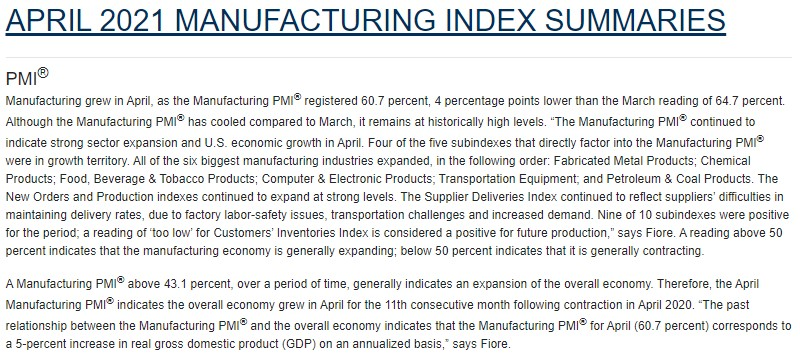


Along the numerical data in each report, the ISM summarizes the survey reponses in a few paragraphs at the beginning of the report, and for each subsection. Additionally, one sections include a selection of quotes from survey respondants. These quote's are often 'soundbite-like' and add sentiment to the report.

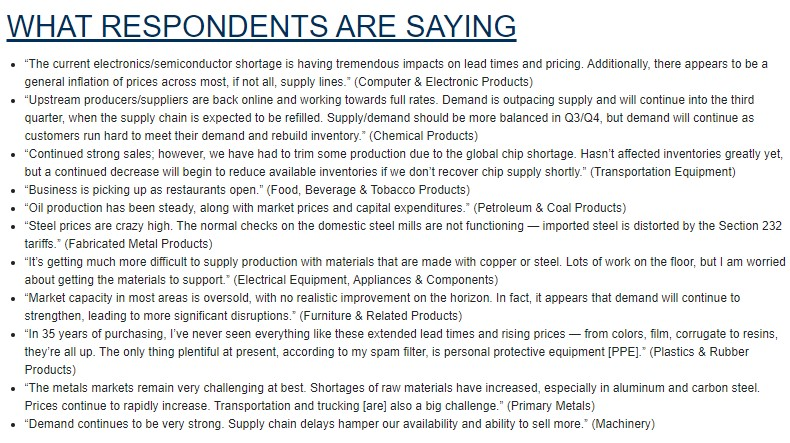



These textual summaries and quotes will be the input to the NLP model. 

## Todo List:
1. Scrape the text data from the PMI and NMI releases.
2. Approriately process the text data with nltk, GenSim, or similar.
3. Perform baseline modelling to choose a set of models to tune further.
4. Write up 
  * Exploration - talk about the important features
  * 3 important one, 3 non important ones
  * bivariate chart showing relation between them
  * show distributions
  * EDA: group categories with high-ratio and low-ratio, instead of having hundreds of categories.
  * Wrangling- describe manipulation and data changes
  * Methods
  * Make a plot n_sample for training, as a function of performance on the validation (always use the same test set). Look for a convergence of the performance after reaching sufficne samples. Use the best hyperparameters, not a grid search. (Try decision tree first, because it's fast.
  * discussion on each model, with summary of advs and disadvs of each model, assumptions
  * Most important  is to describe shortcomings of the data and analysis-room for improvement. Weaknesses/ limitations in the model. Show readers where the model and analysis can be improved.
  * Explain the choices made in the analysis
  * statistical tests of significance
  * Show chart with final perf on test set


## Completed list:
1. Gather and preprocess numerical data from Fed and Quandl.
2. Perform baseline modelling on the numerical data only.
* id important features have strong variation  with target var

# Imports

## Modules

In [1]:
# Set api key variables
% cd "/content/drive/MyDrive/Colab Notebooks/endo-US-econ-analysis"
! cd "/content/drive/MyDrive/Colab Notebooks/endo-US-econ-analysis"
! export PATH=$PATH:'/content/drive/MyDrive/Colab Notebooks/API Keys'

import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/API Keys')

import config
API_KEY = config.API_KEY

from pathlib import Path
working_path = Path('/content/drive/MyDrive/Colab Notebooks/endo-US-econ-analysis')

/content/drive/MyDrive/Colab Notebooks/endo-US-econ-analysis


In [2]:
# install chromium, its driver, and selenium
!apt update
!apt install chromium-chromedriver

!pip install -U beautifulsoup4 selenium
!pip install -U pandas numpy matplotlib seaborn
!pip install -U tsfresh tqdm requests_cache pandas-datareader 
!pip install -U statsmodels scipy hcrystalball pmdarima tbats scrapy


Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad

In [3]:
import re
import pickle
import unicodedata
import requests
import requests_cache
import bs4
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import rcParams

# Get the Data

The archived text of the ISM releases are hard to get, while the numerical data are easy to find. For this data, we'll scrap the news releases from PR News Wire as the ISM releases after 2012 are still available there.

## Web scraping static content with Beautiful Soup and Requests

In [4]:
url_root = 'https://www.prnewswire.com/news/institute-for-supply-management'
urls = [ f'{url_root}/?page={p}&pagesize=100' \
        for p in (1, 2, 3, 4)]
session = requests_cache.CachedSession('news_cache')
headers = {'User-Agents': 'Mozilla/5.0',
           'referer': url_root}

# Identify links of interest
links = []
links_suffixes = []
for url in urls:
  # Use requests to retrieve data from a given URL
  news_response = session.get(url, headers=headers)
  # Parse the whole HTML page using BeautifulSoup
  news_soup = BeautifulSoup(news_response.text, 'html.parser')
  # Get a list of all the links
  for link in news_soup.find_all('a'):
    # print(link.get('href'))
    # print(type(link.get('href')))
    href = str(link.get('href'))
    if 'news-release' in href:
      # Filter the links to include the phrase 'PMI-at'
      if 'pmi-at' in href \
      and 'hospital' not in href \
      and 'services' not in href: 
        suffix = link.get('href').replace('/news-releases', '')
        links.append(f'{url_root}{suffix}')
        links_suffixes.append(suffix)
      # elif 'nmi-at' in str(link.get('href')):
      # links.append(link.get('href'))
direct_links = ['https://www.prnewswire.com/news-releases'+ suffix for suffix in links_suffixes ]
len(links), len(links_suffixes), len(direct_links)

(99, 99, 99)

In [5]:
links

['https://www.prnewswire.com/news/institute-for-supply-management/manufacturing-pmi-at-61-2-may-2021-manufacturing-ism-report-on-business-301301816.html',
 'https://www.prnewswire.com/news/institute-for-supply-management/manufacturing-pmi-at-60-7-april-2021-manufacturing-ism-report-on-business-301281490.html',
 'https://www.prnewswire.com/news/institute-for-supply-management/manufacturing-pmi-at-64-7-march-2021-manufacturing-ism-report-on-business-301260206.html',
 'https://www.prnewswire.com/news/institute-for-supply-management/manufacturing-pmi-at-60-8-february-2021-manufacturing-ism-report-on-business-301236952.html',
 'https://www.prnewswire.com/news/institute-for-supply-management/manufacturing-pmi-at-58-7-january-2021-manufacturing-ism-report-on-business-301218544.html',
 'https://www.prnewswire.com/news/institute-for-supply-management/manufacturing-pmi-at-60-7-december-2020-manufacturing-ism-report-on-business-301200432.html',
 'https://www.prnewswire.com/news/institute-for-supp

In [6]:
# for link in links[0:2]:
print(direct_links[0])
res = session.get(direct_links[0])
soup = BeautifulSoup(res.text, 'html.parser')
soup

https://www.prnewswire.com/news-releases/manufacturing-pmi-at-61-2-may-2021-manufacturing-ism-report-on-business-301301816.html


<!DOCTYPE html>

<html lang="en">
<head>
<meta charset="utf-8"/>
<meta content="IE=edge,chrome=1" http-equiv="X-UA-Compatible"/>
<meta content="width=device-width, initial-scale=1" name="viewport"/><link href="/content/dam/prnewswire/icons/2019-Q4-PRN-Icon-32-32.png" rel="icon" type="image/png"/>
<meta content="//assets.adobedtm.com/launch-ENb957f6e7383d4549b191e1190ed5476e.min" name="adobeLaunchScript"/> <meta content="us-prod" name="optanonhelper"/>
<link href="/etc.clientlibs/prncom/clientlibs/clientlibs-common.min.css" rel="stylesheet" type="text/css"/>
<script src="/etc.clientlibs/prncom/clientlibs/clientlib-library.min.js" type="text/javascript"></script>
<script src="/etc.clientlibs/prncom/clientlibs/component-clientlibs.min.js" type="text/javascript"></script>
<script src="https://widgets.financialcontent.com/cision/stockquote.js" type="text/javascript"></script>
<link href="/etc.clientlibs/prncom/clientlibs/newspage-clientlibs.min.css" rel="stylesheet" type="text/css"/>
<meta 

Lots of info is missing from the text here, while the missing text does show correctly in a web browser. It looks like the interesting content of this page is rendered in the javascript, so we'll need a tool suitable for scraping dyanmic web pages.

## Web scraping dynamic content with Selenium

In [7]:
# from selenium.webdriver import ChromeOptions, Chrome
# # from selenium.webdriver.support import expected_conditions as EC
# # from selenium.webdriver.common.by import By
# # from selenium.webdriver.support.ui import WebDriverWait

# def start_new_driver():
#   # set options to be headless, ..
#   options = ChromeOptions()
#   options.add_argument('--headless')
#   options.add_argument('--no-sandbox')
#   options.add_argument('--disable-dev-shm-usage')
#   prefs = {
#       # Skip loading images
#       'profile.managed_default_content_settings.images':2,
#       # Use disk cache
#       "profile.managed_default_content_settings.images": 2,
#       'disk-cache-size': 4096
#       }
#   options.add_experimental_option("prefs", prefs)
#   # open it, go to a website, and get results
#   driver = Chrome(options=options)
#   return driver

# # Get page sources
# page_sources = []
# page_urls = []
# for direct_link in tqdm(direct_links, desc='direct_links'):
#     driver = start_new_driver()
#     driver.get(direct_link)
#     raw_page_source = driver.page_source
#     # Unicode-normalize the source
#     normalized_page_source = unicodedata.normalize('NFKD', raw_page_source)
#     page_sources.append(normalized_page_source)
#     page_urls.append(driver.current_url)
#     driver.close()

# # Save page sources
# page_sources_path = working_path / 'data/intermediate/page_sources/page_sources.pkl'
# with open(page_sources_path, 'wb') as f:
#   pickle.dump(page_sources, f)

# page_urls_path = working_path / 'data/intermediate/page_sources/page_urls.pkl'
# with open(page_urls_path, 'wb') as f:
#   pickle.dump(page_urls, f)

# len(page_sources), len(page_urls)

In [8]:
# Load page sources with this cell, or uncomment cell above to scrape fresh data (it's slow)
page_sources_path = working_path / 'data/intermediate/page_sources/page_sources.pkl'
with open(page_sources_path, 'rb') as f:
  page_sources = pickle.load(f)

page_urls_path = working_path / 'data/intermediate/page_sources/page_urls.pkl'
with open(page_sources_path, 'rb') as f:
  page_urls =  pickle.load(f)

len(page_sources), len(page_urls)

(99, 99)

In [9]:
normalized_page_sources = []
for raw_page_source in page_sources:
  normalized_page_sources.append(unicodedata.normalize('NFKD', raw_page_source))
page_sources = normalized_page_sources

# Assert that all urls and page_sources are unique
df = pd.DataFrame({'url': page_urls, 'page_source': page_sources})
assert df['url'].is_unique
assert df['page_source'].is_unique

len(page_sources)

99

# Parse the data

## Release body

In [10]:
#Parse release_bodies from page source
releases = []
paragraphs_all_releases_soup = []
paragraphs_all_releases_text = []
for i, release_page_source in enumerate(page_sources):
  # print(release_page_source)
  release = {}
  soup = BeautifulSoup(release_page_source, 'html.parser')
  release['release_body'] = soup.find('section', 'release-body')
  paragraphs_this_release = release['release_body'].find_all('p')
  release['paragraphs'] =  paragraphs_this_release
  for paragraph in paragraphs_this_release:
    paragraphs_all_releases_soup.append(paragraph)
    paragraphs_all_releases_text.append(paragraph.text)
  # Select the first date in the release body
  date = release['release_body'].select('span.xn-chron')[1].text
  # print(date)
  # print(release['paragraphs'][0:5])
  release['date'] = date
  releases.append(release)
len(releases), len(paragraphs_all_releases_soup), len(paragraphs_all_releases_text)

(99, 62940, 62940)

### Tests: Check the properties of the release bodies

In [11]:
# check to make sure the release bodies are unique
df = pd.DataFrame.from_dict(releases)
assert df['release_body'].is_unique
assert df['paragraphs'].apply(repr).is_unique

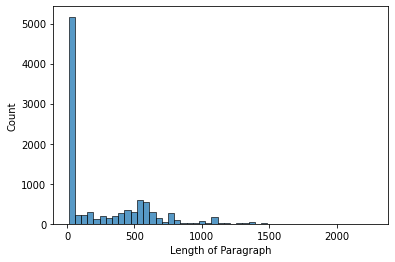

In [12]:
# Compare number of paragraphs in different releases to see if the number is constant,
# which would indicate a stable paragraph structure in the text
lengths = []
for paragraph_text in paragraphs_all_releases_text:
  # ignore paragraphs shorter than 10:
  if len(paragraph_text)>10:
    lengths.append(len(paragraph_text)) 
lengths_hist = sns.histplot(lengths)
lengths_hist.set(xlabel='Length of Paragraph');

No conclusion can be made with the paragraph structure alone.

Some paragraphs  not unique. What are the most common paragraphs?


In [13]:
# check for paragraphs that are repeated accross multiple releases.
all_paragraphs_series = pd.Series(paragraphs_all_releases_text, name='paragraphs_all_releases_text')
all_paragraphs_series.is_unique

False

We see that there are non-unique paragraphs in the corpus. Which are they?

In [14]:
all_paragraphs_series.value_counts()

Index                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            1092
Net                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

## Relevant Paragraphs

The paragraphs groups of interest are:
* Summary
* What Respondants are Saying 
* Commodities Up in Price 
* Commodities Down in Price 
* Commodities in Short Supply

Other paragraphs will not be included in this notebook.

All the PMI reports include the same paragraph groups, except for minor and infrequent changes to format, such as when the ISM changed the name of the report from PMI to Manufacturing PMI.

### Summary

In [18]:
# Parse from the top and group the text as the first group, summary. 
# Stop parsing upon encountering the string: 'WHAT RESPONDENTS ARE SAYING'

import dateutil.parser

def parse_summary(paragraphs: bs4.element.ResultSet):
  summary_paragraphs_by_release = []
  for paragraph in paragraphs:
    text = unicodedata.normalize('NFKD', paragraph.text)
    # fix unicode change to a common string, PMITM to PMI
    text = re.sub('( PMITM )|( PMI® )', ' PMI ', text)
    if not text:
      # Some paragraphs are exclusively whitespace, so exclude these
      continue
    elif re.match('.*DO NOT CONFUSE THIS NATIONAL REPORT.*', text):
      # Exclude this non-informative paragraph that only clarifies that this 
      # report is not the same  as another report
      continue
    elif re.match('^.+\/PRNewswire\/ -- ', text):
      # Remove this portion of paragraph, containing only the location, date and byline of the news outlet
      # Keep remainder of paragraph
      summary_paragraphs_by_release.append(re.sub('^.+\/PRNewswire\/ -- ', '', text))
    elif re.match('^The report was issued today by.*Survey Committee.\s', text):
      # Remove this portion of paragraph, containing only person presenting the report
      # Keep remainder of paragraph
      summary_paragraphs_by_release.append(re.sub('^The report was issued today by.*Survey Committee.\s', '', text))
    elif 'WHAT RESPONDENTS ARE SAYING' in text:
      #End of summary section; beginning of next section
      break
    else:
      summary_paragraphs_by_release.append(text)
  return summary_paragraphs_by_release

summary_paragraphs_by_release = [parse_summary(release['paragraphs']) for release in releases]
len(summary_paragraphs_by_release)

99

In [19]:
summary_paragraphs_by_release[:1]

[["New Orders, Production & Employment Growing; Supplier Deliveries Slowing at Faster Rate; Backlog Growing; Raw Materials Inventories Growing; Customers' Inventories Too Low; Prices Increasing; Exports and Imports Growing",
  "Economic activity in the manufacturing sector grew in May, with the overall economy notching a 12th consecutive month of growth, say the nation's supply executives in the latest Manufacturing ISM® Report On Business®.",
  'The report was issued today by Timothy R. Fiore, CPSM, C.P.M., Chair of the Institute for Supply Management® (ISM®) Manufacturing Business Survey Committee:',
  '"The May Manufacturing PMI registered 61.2 percent, an increase of 0.5 percentage point from the April reading of 60.7 percent. This figure indicates expansion in the overall economy for the 12th month in a row after contraction in April 2020. The New Orders Index registered 67 percent, increasing 2.7 percentage points from the April reading of 64.3 percent. The Production Index regis

In [20]:
summary_paragraphs_flat_by_release = []
for summary_paragraphs in summary_paragraphs_by_release:
  summary_paragraphs_flat_by_release.append(' '.join(summary_paragraphs))

<AxesSubplot:>

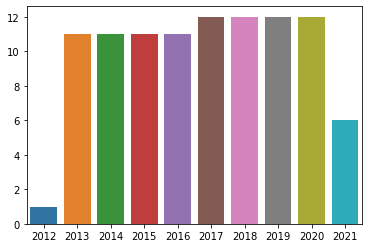

In [23]:
def parse_date(paragraphs: bs4.element.ResultSet):
  for paragraph in paragraphs:
    text = unicodedata.normalize('NFKD', paragraph.text)
    # Parse the date from this paragraph
    match = re.match('^.+\/PRNewswire\/ -- ', text)
    if match:
      # print(paragraph)
      date_string = paragraph.select('span.xn-chron')[0].text
      return pd.to_datetime(date_string)

release_dates = [parse_date(release['paragraphs']) for release in releases]
dates_count = pd.Series(release_dates).dt.year.value_counts()
sns.barplot(x=dates_count.index,
            y=dates_count)

We can see that there are some missing months. These releases are missing from the news relese source, unfortunately.

Missing years and month: 
* 2013: 3,
* 2014: 5, 
* 2015: 8, 
* 2016: 11

In [24]:
summary_paragraphs[0]

"Economic activity in the manufacturing sector contracted in November following two months of modest expansion, while the overall economy grew for the 42nd consecutive month, say the nation's supply executives in the latest Manufacturing ISM Report On Business®."

### What Respondants are Saying

This section contain quotes from the anonymous supply managers responding to the survey. These quotes may be cherry-picked by the decision makers who compile the report, but this section of the report is probably the most useful as an input into and NLP sentiment analysis model.

In [25]:
# abbreviation: wras = what_respondants_are_saying
def parse_wras(releases: list):
  wras_soups = []
  wras_texts = []
  wras_soups_flat = []
  wras_texts_flat = []
  for release in tqdm(releases):
    wras_soup = release['release_body'].find_all('li')
    wras_soups.append(wras_soup)

    wras_text = [unicodedata.normalize('NFKD', tag.text.strip()) for tag in wras_soup]
    wras_texts.append(wras_text)
    
    for tag in wras_soup:
      wras_soups_flat.append(tag)
    for text in wras_text:
      wras_texts_flat.append(text)
  assert len(wras_soups)==len(wras_texts)
  assert len(wras_soups_flat)==len(wras_texts_flat)
  return (wras_soups,  # List of lists of soups
          wras_texts,    # List of lists of texts
          wras_soups_flat, # lists of soups
          wras_texts_flat) # lists of texts

(wras_soups,
  wras_texts,  
  wras_soups_flat,
  wras_texts_flat) = parse_wras(releases)  

len(wras_soups), len(wras_texts), len(wras_soups_flat), len(wras_texts_flat)

  0%|          | 0/99 [00:00<?, ?it/s]

(99, 99, 998, 998)

In [26]:
wras_texts[:1]

[['"Supplier performance — deliveries, quality, it\'s all suffering. Demand is high, and we are struggling to find employees to help us keep up." [Computer & Electronic Products]',
  '"Changes in currency exchange rates favorably contributed to our quarterly performance. Continued strong consumer demand for our high-quality products also provided increased sales." [Chemical Products]',
  '"Ongoing component shortages are driving dual sourcing and longer-term supply plans to be implemented." [Transportation Equipment]',
  '"Difficulty finding workers at the factory and warehouse level is not only impacting our production, but suppliers\' as well: Spot shortages and delays are common due to an inability to staff lines. Delays at the port continue to strain inventory levels." [Food, Beverage & Tobacco Products]',
  '"[A] lack of qualified candidates to fill both open office and shop positions is having a negative impact on production throughput. Challenges mounting for meeting delivery da

#### Parse WRAS quote and industry

In [27]:
wras_tuples_by_release = []
wras_tuples_flat = []
for quote_and_ind_str_list in wras_texts:
  inner_wras_tuples = []
  for quote_and_ind_str in quote_and_ind_str_list:
    match_0 = re.match('\"?(.+)\"?\s\((.*)\)', quote_and_ind_str)
    match_1 = re.match('"(.*")\s+[/(/[]([A-Z].*)[\]\)]', quote_and_ind_str)
    if match_0:
      # print(match_0)
      # print(match_0.group(1)[:20], match_0.group(2))
      inner_wras_tuples.append((match_0.group(1), match_0.group(2)))
      wras_tuples_flat.append((match_0.group(1), match_0.group(2)))
    elif match_1:
      # print(match_1)
      # print(match_1.group(1)[:20], match_1.group(2))
      inner_wras_tuples.append((match_1.group(1), match_1.group(2)))
      wras_tuples_flat.append((match_1.group(1), match_1.group(2)))
    else:
      # Too few to matter (<4), ignore precessing these outliers; just append as-is
      # print(quote_and_ind_str)
      continue
  wras_tuples_by_release.append(inner_wras_tuples)

len(wras_tuples_by_release), len(wras_tuples_flat)

(99, 997)

In [28]:
wras_tuples_by_release[:1]

[[('Supplier performance — deliveries, quality, it\'s all suffering. Demand is high, and we are struggling to find employees to help us keep up."',
   'Computer & Electronic Products'),
  ('Changes in currency exchange rates favorably contributed to our quarterly performance. Continued strong consumer demand for our high-quality products also provided increased sales."',
   'Chemical Products'),
  ('Ongoing component shortages are driving dual sourcing and longer-term supply plans to be implemented."',
   'Transportation Equipment'),
  ('Difficulty finding workers at the factory and warehouse level is not only impacting our production, but suppliers\' as well: Spot shortages and delays are common due to an inability to staff lines. Delays at the port continue to strain inventory levels."',
   'Food, Beverage & Tobacco Products'),
  ('[A] lack of qualified candidates to fill both open office and shop positions is having a negative impact on production throughput. Challenges mounting for

In [29]:
wras_texts_by_release = []
wras_texts_flat_by_release = []
wras_industries_by_release = []
wras_industries_flat_by_release = []
for wras_tuples in wras_tuples_by_release:
  wras_text, wras_industries = zip(*wras_tuples)
  wras_text_flat = ' '.join(wras_text)
  wras_industries_flat = ' '.join(wras_industries)

  wras_texts_by_release.append(wras_text)
  wras_texts_flat_by_release.append(wras_text_flat)
  wras_industries_by_release.append(wras_industries)
  wras_industries_flat_by_release.append(wras_industries_flat)

### Commodities Up, Down, and in short supply

This section is not likely to be useful for a sentiment analysis. But, this does appear to be a useful source of categorical data that could later be transformed into usefuls numerical series as an input to any model.

One possible modelling application would be to test a hypothesis that the data in this section is a leading indicator of commodity prices.

#### Parse commodites up/down in price and short supply from Paragraphs

In [30]:
comm_up_lists = []
comm_down_lists = []
comm_short_lists = []
comm_up_lists_flat = []
comm_down_lists_flat = []
comm_short_lists_flat = []
for i, release in enumerate(releases):
  # Up
  comm_up_inter_str = unicodedata.normalize('NFKD', release['release_body'].find(string=re.compile('Commodities\sUp\sin\sPrice')).find_parent('p').get_text().replace('Commodities Up in Price', '').strip())
  if not comm_up_inter_str:
    # print('if up_4')
    comm_up_inter_str = release['release_body'].find(string=re.compile('Commodities\sUp\sin\sPrice')).find_parent('p').next_sibling.next_sibling.get_text()
  
  if re.match('The only commodity listed up in price.+is\s',comm_up_inter_str):
    # print('up_match_1')
    comm_up_str = re.sub('The only commodity listed up in price.+is\s', '', comm_up_inter_str)
  else:
    comm_up_str = comm_up_inter_str
  
  if re.search('Commodities', comm_up_str):
    comm_up_str = release['release_body'].find(string=re.compile('Commodities\sUp\sin\sPrice')).find_parent('span').get_text().replace('Commodities Up in Price', '').strip()
  
  # Source forgot a semi-colon one time
  if comm_up_inter_str == 'Aluminum*; Electronic Components (7); Paper-Based Products; Plastic Components; Printed Circuit Board Assemblies (2); Steel* (6); Steel — Hot Rolled* (2) and Steel Products* (10).':
    comm_up_str = 'Aluminum*; Electronic Components (7); Paper-Based Products; Plastic Components; Printed Circuit Board Assemblies (2); Steel* (6); Steel — Hot Rolled* (2); and Steel Products* (10).'
  
  assert comm_up_str
  assert not re.search('Commodities', comm_up_str)
  # print(i, '\t', comm_up_str)

  # Down
  comm_down_heading_text = release['release_body'].find(string=re.compile('Commodities\sDown\sin\sPrice'))
  if comm_down_heading_text:
    if 'Up' in comm_down_heading_text.find_parent('p').get_text().replace('Commodities Down in Price', '').strip():
      # print('if Up')
      comm_down_inter_str = release['release_body'].find(string=re.compile('Commodities\sDown\sin\sPrice')).find_parent().find_parent().get_text()
    else:
      comm_down_inter_str = comm_down_heading_text.find_parent('p').get_text().replace('Commodities Down in Price', '').strip()
    comm_down_str = re.sub('Commodities\sDown\sin\sPrice', '', comm_down_inter_str).strip()
    if not comm_down_str:
      # print('if down_4')
      comm_down_str = release['release_body'].find(string=re.compile('Commodities\sDown\sin\sPrice')).find_parent('p').next_sibling.next_sibling.get_text()
  else:
    # print('if 2')
    comm_down_inter_str = release['release_body'].find(string=re.compile('Commodities\sUp\sin\sPrice')).find_parent('p').next_sibling.next_sibling.get_text()
    comm_down_str = re.sub('Commodities\sDown\sin\sPrice', '', comm_down_inter_str).strip()
    if not comm_down_str:
      # print('if 3')
      comm_down_str = release['release_body'].find(string=re.compile('Commodities\sUp\sin\sPrice')).find_parent('p').next_sibling.next_sibling.next_sibling.get_text()
  assert comm_down_str
  assert not re.search('Commodities', comm_down_str)
  # print(i, '\t', comm_down_str) 

  # Short
  comm_short_inter_str = unicodedata.normalize('NFKD', release['release_body'].find(string=re.compile('Commodities\sin\sShort\sSupply')).find_parent('p').get_text().replace('Commodities in Short Supply', '').strip())
  if re.match('[Nn]o\scommodities\s.*\sshort\ssupply',comm_short_inter_str):
    # print(i, 'short_match_1')
    comm_short_str = re.sub('.*[Nn]o\scommodities\s.*\sshort\ssupply.*', 'None.', comm_short_inter_str)
  elif re.match('.*\sis\sthe\sonly\scommodity.*',comm_short_inter_str):
    # print(i, 'short_match_2')
    comm_short_str = re.sub('\sis\sthe\sonly\scommodity.*', '', comm_short_inter_str)
  elif re.match('.*no commodities listed in short supply.*', comm_short_inter_str):
    # print(i, 'short_match_3')
    comm_short_str = re.sub('^.*no commodities listed in short supply.*', 'None.', comm_short_inter_str)
  elif re.match('The only commodity.*short supply.*is\s', comm_short_inter_str):
    # print(i, 'short_match_4')
    comm_short_str = re.sub('The only commodity.*short supply.*is\s', '', comm_short_inter_str)
  elif re.match('Commodities\s.*in', comm_short_inter_str):
    # print(i, 'short_match_5')
    comm_short_str = release['release_body'].find(string=re.compile('Commodities\sin\sShort\sSupply')).find_parent('span').get_text().replace('Commodities in Short Supply ', '').strip()
  else:
    comm_short_str = comm_short_inter_str
  assert comm_short_str
  assert not re.search('Commodities', comm_short_str)

  # if re.match('Commodities\s.*in', comm_short_str):
  #   print(i, comm_short_str)
  #   raise
  # print(i, '\t', comm_short_str)
  # print(comm_short_str)
  
  # Remove any final '.'
  comm_up_list = re.sub('\.$', '', comm_up_str)
  comm_down_list = re.sub('\.$', '', comm_down_str)
  comm_short_list = re.sub('\.$', '', comm_short_str)

  # Split string into list at ';'
  comm_up_list = comm_up_str.split('; ')
  comm_down_list = comm_down_str.split('; ')
  comm_short_list = comm_short_str.split('; ')

  # # strip white space
  comm_up_list = [ele.strip() for ele in comm_up_list]
  comm_down_list = [ele.strip() for ele in comm_down_list]
  comm_short_list = [ele.strip() for ele in comm_short_list]

  # Append to list
  comm_up_lists.append(comm_up_list)
  comm_down_lists.append(comm_down_list)
  comm_short_lists.append(comm_short_list)

  for ele in comm_up_list:
    comm_up_lists_flat.append(ele)
  for ele in comm_down_list:
    comm_down_lists_flat.append(ele)
  for ele in comm_short_list:
    comm_short_lists_flat.append(ele)


In [31]:
# Check lengths
len(comm_up_lists), len(comm_down_lists), len(comm_short_lists)

(99, 99, 99)

In [32]:
# Check lengths
len(comm_up_lists_flat), len(comm_down_lists_flat), len(comm_short_lists_flat)

(1342, 575, 422)

#### Parse commodities and months Up/Down/Short-supply from "Commodites Up/Down in Price and Short Supply"

In [33]:
def parse_commodities_up_down_short_string(commodity_str, debug=False):
  # Remove unicode and Replace *
  commodity_str = unicodedata.normalize('NFKD', commodity_str).replace('*', '')

  # Check for 'None'
  match_none_no_digits = re.match('^None.$', commodity_str)
  match_none_digits = re.match('^None\s\((\d+)\)\.$', commodity_str)

  # Check for 'no commoditites are...'
  match_no_commod_no_digits = re.match('No commodities are', commodity_str)
  match_no_commod_digits = re.match('No commodities are.* \((\d+)\)', commodity_str)
  # Check for 'only commodity...'
  match_only_commodity_digits = re.match('(.+) \((\d+)\) is the only commodity.*', commodity_str)
  match_only_commodity_no_digits = re.match('([A-Z0-9#].*) is the only commodity.+\.', commodity_str)
  
  if match_none_no_digits or match_no_commod_no_digits:
    commod_str = 'None'
    digits = 1
    tup = (commod_str, digits)
    if debug:
      print('match_none_no_digits or match_no_commod_no_digits')
      print(commodity_str)
      print(tup)
  elif match_none_digits:
    commod_str = 'None'
    digits = int(match_none_digits.group(1))
    tup = (commod_str, digits)
    if debug:
      print('match_none_digits')
      print(commodity_str)
      print(tup)
  elif match_no_commod_digits:
    commod_str = 'None'
    digits = int(match_no_commod_digits.group(1))
    tup = (commod_str, digits)
    if debug:
      print('match_no_commod')
      print(commodity_str)
      print(tup)
  elif match_only_commodity_no_digits:
    commod_str = match_only_commodity_no_digits.group(1)
    digits = 1
    tup = (commod_str, digits)
    if debug:
      print('match_only_commodity_no_digits')
      print(commodity_str)
      print(tup)
  elif match_only_commodity_digits:
    commod_str = match_only_commodity_digits.group(1)
    digits = match_only_commodity_digits.group(2)
    tup = (commod_str, digits)
    if debug:
      print('match_only_commodity_no_digits')
      print(commodity_str)
      print(tup)
  else:
    # Check for 'and...commod_str..(digits)
    match_2 = re.match('^and\s([A-Z#\d].*)\s\((\d+)\)', commodity_str) # and..., with no period at end
    match_3 = re.match('^and\s(.*)', commodity_str)
    if match_2:
      commod_str = match_2.group(1)
      digits = int(match_2.group(2))
      tup = (commod_str, digits)
      if debug:
        print('match_2')
        print(commodity_str)
        print(i, match_2.groups())
        print(tup)
    elif match_3:
      commod_str = re.sub('\.$', '', match_3.group(1))
      digits = 1
      tup = (commod_str, digits)
      if debug:
        print('match_3')
        print(commodity_str)
        print(i, match_3.groups())
        print(tup)
    else:
      # Check for 'comod_str...(digits)
      match_4 = re.match('^([A-Z0-9#].*)\s\((\d+)\)$', commodity_str)
      match_5 = re.match('^([A-Z0-9#].*)', commodity_str)
      if match_4:
        commod_str = match_4.group(1)
        digits = int(match_4.group(2))
        tup = (commod_str, digits)
        if debug:
          print('match_4')
          print(commodity_str)
          print(i, match_4.groups())
          print(tup)
      elif  match_5:
        commod_str = match_5.group(1)
        digits = 1
        tup = (commod_str, digits)
        if debug:
          print('match_5')
          print(commodity_str)
          print(i, match_5.groups())
          print(tup)
      else:
        # If it doesn't match any ohter regular expression
        print(i, commodity_str)
        raise Error
  return tup

In [34]:
commodities_up_by_release = []
for comm_up_list in comm_up_lists:
  this_release = []
  for commod_up in comm_up_list:
    this_release.append(parse_commodities_up_down_short_string(commod_up))
  commodities_up_by_release.append(this_release)

commodities_down_by_release = []
for comm_down_list in comm_down_lists:
  this_release = []
  for commod_down in comm_down_list:
    this_release.append(parse_commodities_up_down_short_string(commod_down))
  commodities_down_by_release.append(this_release)

commodities_short_by_release = []
for comm_short_list in comm_short_lists:
  this_release = []
  for commod_short in comm_short_list:
    this_release.append(parse_commodities_up_down_short_string(commod_short))
  commodities_short_by_release.append(this_release)

In [35]:
len(commodities_up_by_release), len(commodities_down_by_release), len(commodities_short_by_release)

(99, 99, 99)

In [36]:
commodities_names_up_by_release = []
commodities_names_up_flat_by_release = []
for tup in commodities_up_by_release:
  commodities_names_up, _ = zip(*tup)
  commodities_names_up_by_release.append(commodities_names_up)
  commodities_names_up_flat_by_release.append(', '.join(commodities_names_up))

commodities_names_down_by_release = []
commodities_names_down_flat_by_release = []
for tup in commodities_down_by_release:
  commodities_names_down, _ = zip(*tup)
  commodities_names_down_by_release.append(commodities_names_down)
  commodities_names_down_flat_by_release.append(', '.join(commodities_names_down))

commodities_names_short_by_release = []
commodities_names_short_flat_by_release = []
for tup in commodities_short_by_release:
  commodities_names_short, _ = zip(*tup)
  commodities_names_short_by_release.append(commodities_names_up)
  commodities_names_short_flat_by_release.append(', '.join(commodities_names_short))

##### Check Outputs

In [ ]:
# # Check output tuples make sense with input strings
# for i in range(len(commodities_names_up_by_release)):
#   print(f'{i},\t{comm_up_lists[i][0]},\t{commodities_up_by_release[i][0]}')

In [ ]:
# # Check output tuples make sense with input strings
# for i in range(len(commodities_down_by_release)):
#   print(f'{i},\t{comm_down_lists[i][0]},\t{commodities_down_by_release[i][0]}')

In [ ]:
# # Check output tuples make sense with input strings
# for i in range(len(commodities_short_by_release)):
#   print(f'{i},\t{comm_short_lists[i][0]},\t{commodities_short_by_release[i][0]}')

## Variables for further use:

`summary_paragraphs`,
`wras_tuples`,
`commodities_up`,
`commodities_down`,
`commodities_short`,

### Check the variables

In [ ]:
# summary_paragraphs[0]

In [ ]:
# wras_texts_flat_by_release[2]

In [ ]:
# commodities_up_by_release[0]

In [ ]:
# commodities_down_by_release[0]

In [ ]:
# commodities_short_by_release[0]

# Make dataframes from parsed variables

In [52]:
dates_ser = pd.Series(release_dates, name='date')

summary_ser = pd.Series( summary_paragraphs_flat_by_release, 
                        name='summary')

wras_text_ser = pd.Series(wras_texts_flat_by_release, name='wras_text')

commodities_up_ser = pd.Series(commodities_names_up_flat_by_release, name='commodities_up_in_price')
commodities_up_count_ser = pd.Series([len(commodities_up) for commodities_up in commodities_up_by_release], 
                                     name='commodities_up_count')

commodities_down_ser = pd.Series(commodities_names_down_flat_by_release, name='commodities_down_in_price')
commodities_down_count_ser = pd.Series([len(commodities_down) for commodities_down in commodities_down_by_release], 
                                       name='commodities_down_count')

commodities_short_ser = pd.Series(commodities_names_short_flat_by_release, name='commodities_in_short_supply')
commodities_short_count_ser = pd.Series([len(commodities_short) for commodities_short in commodities_short_by_release], 
                                        name='commodities_short_count')

df = pd.DataFrame(data=[dates_ser,
                        summary_ser,
                        wras_text_ser,
                        commodities_up_ser,
                        commodities_up_count_ser,
                        commodities_down_ser,
                        commodities_down_count_ser,
                        commodities_short_ser,
                        commodities_short_count_ser]).T
df['date'] = pd.to_datetime(df['date'])
df['summary'] = df['summary'].astype('string')
df['wras_text'] = df['wras_text'].astype('string')
df['commodities_up_count'] = df['commodities_up_count'].astype(int)
df['commodities_down_count'] = df['commodities_down_count'].astype(int)
df['commodities_short_count'] = df['commodities_short_count'].astype(int)
df = df.set_index('date').sort_index()
df

,summary,wras_text,commodities_up_in_price,commodities_up_count,commodities_down_in_price,commodities_down_count,commodities_short_in_price,commodities_short_count
date,,,,,,,,
2012-12-03,Economic activity in the manufacturing sector ...,Conditions still appear to be positive for con...,"Aluminum Products, Caustic Soda, Corrugated Bo...",7,"Fuel, Oil, Steel",3,None,1
2013-01-02,Economic activity in the manufacturing sector ...,Many Chinese sources are coming to us with cos...,"Aluminum Products, Benzene, Caustic Soda, Corn...",11,"Eggs, Steel, Sugar, Titanium Dioxide",4,None,1
2013-02-01,This report reflects the U.S. Department of Co...,"Fiscal cliff, uncertainty in general and EU ec...","Aluminum Products, Benzene, Caustic Soda, Copp...",15,"Steel, Sugar, Titanium Dioxide, Wheat",4,None,1
2013-04-01,Economic activity in the manufacturing sector ...,Beginning to feel the seasonal upswing in busi...,"Corrugated Boxes, HDPE, Lumber, Pallets, Plast...",6,"Sugar, Wheat",2,None,1
2013-05-01,Economic activity in the manufacturing sector ...,"Business can be described as flat at best."" Pr...","Caustic Soda, Corrugated Boxes, HDPE, Lumber, ...",7,"Aluminum, Steel, Steel — Cold Rolled",3,None,1
...,...,...,...,...,...,...,...,...
2021-02-01,"New Orders, Production & Employment Growing; S...",Supplier factory capacity is well utilized. In...,"Acrylonitrile Butadiene Styrene (ABS) Plastic,...",47,Caustic Soda.,1,"Copper, Corrugate, Corrugated Boxes, Electrica...",12
2021-03-01,"New Orders, Production & Employment Growing Su...",The coronavirus [COVID-19] pandemic is affecti...,"Acetone, Acrylonitrile Butadiene Styrene (ABS)...",48,Dairy.,1,"Acetone, Aluminum, Computer Displays/Monitors,...",20
2021-04-01,"New Orders, Production & Employment Growing; S...",Late-winter storms in unexpected [areas] of th...,"Acetone, Acrylonitrile Butadiene Styrene (ABS)...",56,None,1,"Adhesives, Corrugated Boxes, Electrical Compon...",26


In [53]:
df.isna().sum()

summary                       0
wras_text                     0
commodities_up_in_price       0
commodities_up_count          0
commodities_down_in_price     0
commodities_down_count        0
commodities_short_in_price    0
commodities_short_count       0
dtype: int64

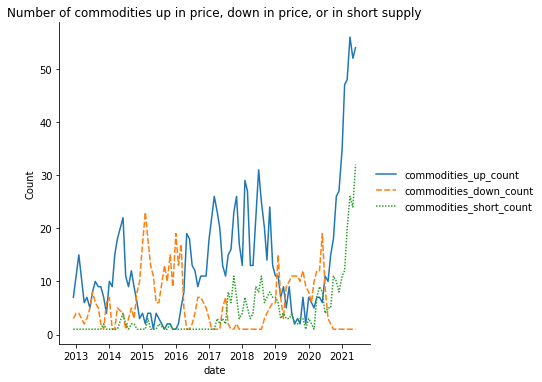

In [54]:
g= sns.relplot(data=df,
                kind='line')
g.set(ylabel='Count',
      title='Number of commodities up in price, down in price, or in short supply');

We can see from the plot that, recently, more commodities are up in price than at any other time since 2012, and more commodities are in short supply than at any other time since 2012.